# Guided Example Drill
So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

## Import the Data
Here we'll use data from Lending Club (2015) to predict the state of a loan given some information about it. You can download the dataset [here](https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,Bookkeeper/Accounting,10+ years,MORTGAGE,48000.0,Not Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,297xx,SC,33.18,0.0,Jun-1991,0.0,33.0,2.0,11.0,2.0,19108.0,29.6%,19.0,w,13668.88,13668.88,4519.68,4519.68,2331.12,2188.56,0.0,0.0,0.0,Jan-2017,379.39,Jan-2017,Jan-2017,0.0,33.0,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,31329.0,1.0,2.0,1.0,2.0,6.0,12221.0,91.0,1.0,4.0,14982.0,65.0,284700.0,0.0,0.0,1.0,6.0,2848.0,263953.0,17.6,0.0,0.0,131.0,294.0,11.0,6.0,2.0,11.0,76.0,11.0,76.0,2.0,6.0,9.0,6.0,8.0,6.0,9.0,11.0,9.0,11.0,0.0,0.0,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,tech,8 years,MORTGAGE,60000.0,Not Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,299xx,SC,22.44,0.0,Jun-1996,0.0,NaN,NaN,7.0,0.0,7722.0,59.4%,9.0,w,6635.69,6635.69,3572.97,3572.97,2964.31,608.66,0.0,0.0,0.0,Jan-2017,298.58,Jan-2017,Jan-2017,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,55387.0,0.0,3.0,0.0,0.0,47.0,47665.0,43.0,2.0,2.0,4744.0,50.0,13000.0,0.0,0.0,2.0,2.0,7912.0,4778.0,61.8,0.0,0.0,234.0,91.0,9.0,9.0,0.0,11.0,NaN,9.0,NaN,0.0,3.0,3.0,3.0,3.0,5.0,4.0,4.0,3.0,7.0,0.0,0.0,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,Sales Manager,10+ years,MORTGAGE,109000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,226xx,VA,26.02,0.0,Dec-2001,1.0,NaN,NaN,9.0,0.0,20862.0,54.3%,19.0,w,0.00,0.00,26224.23,26224.23,25000.00,1224.23,0.0,0.0,0.0,Sep-2016,20807.39,NaN,Jan-2017,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,305781.0,0.0,3.0,0.0,1.0,13.0,47194.0,58.0,0.0,1.0,8937.0,57.0,38400.0,1.0,0.0,1.0,2.0,33976.0,17538.0,54.3,0.0,0.0,142.0,168.0,13.0,13.0,3.0,13.0,NaN,0.0,NaN,0.0,3.0,3.0,5.0,6.0,7.0,5.0,9.0,3.0,9.0,0.0,0.0,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,Senior Manager,10+ years,MORTGAGE,92000.0,Not Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,275xx,NC,21.60,0.0,May-1984,0.0,42.0,NaN,16.0,0.0,51507.0,6

## Data Cleaning 
For our model lets remove all columns with unique variables over 30. This will free up memory for the get_dummies on specific categorical variables.

In [3]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


In [4]:
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip(
    '%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['id', 'member_id', 'url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

y2015.tail()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,RENT,35000.0,Verified,Jan-2015,Charged Off,n,debt_consolidation,Debt consolidation,30.90,0.0,0.0,NaN,84.0,9.0,1.0,11031.0,22.0,w,0.00,0.00,5034.02,5034.02,2527.70,2506.32,0.0,0.00,0.0000,May-2016,316.07,NaN,Dec-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,34178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18000.0,NaN,NaN,NaN,7.0,3798.0,2554.0,75.9,0.0,0.0,134.0,108.0,6.0,6.0,0.0,17.0,NaN,10.0,NaN,0.0,4.0,6.0,4.0,4.0,12.0,7.0,10.0,6.0,9.0,0.0,0.0,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,RENT,64400.0,Source Verified,Jan-2015,Charged Off,n,debt_consolidation,Debt consolidation,27.19,1.0,2.0,22.0,NaN,17.0,0.0,8254.0,20.0,w,0.00,0.00,5366.99,5366.99,1552.69,2234.98,0.0,1579.32,284.2776,Jan-2016,317.86,NaN,Oct-2016,1.0,22.0,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,58418.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27000.0,NaN,NaN,NaN,6.0,3895.0,3752.0,61.3,0.0,0.0,56.0,83.0,5.0,5.0,0.0,12.0,NaN,0.0,NaN,1.0,5.0,7.0,7.0,7.0,3.0,15.0,16.0,7.0,17.0,0.0,0.0,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,RENT,100000.0,Verified,Jan-2015,Current,n,credit_card,Credit card refinancing,10.83,0.0,1.0,NaN,110.0,8.0,1.0,33266.0,10.0,f,7475.67,7475.67,15966.05,15966.05,12524.33,3441.72,0.0,0.00,0.0000,Jan-2017,664.20,Feb-2017,Jan-2017,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,33307.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41700.0,NaN,NaN,NaN,1.0,4163.0,8434.0,79.8,0.0,0.0,146.0,155.0,5.0,5.0,0.0,5.0,NaN,0.0,NaN,0.0,5.0,5.0,6.0,7.0,1.0,6.0,7.0,5.0,8.0,0.0,0.0,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [5]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]
pd.get_dummies(y2015).tail()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,issue_d_Apr-2015,issue_d_Aug-2015,issue_d_Dec-2015,issue_d_Feb-2015,issue_d_Jan-2015,issue_d_Jul-2015,issue_d_Jun-2015,issue_d_Mar-2015,issue_d_May-2015,issue_d_Nov-2015,issue_d_Oct-2015,issue_d_Sep-2015,loan_status_Charged Off,loan_status_Current,loan_status_Default,loan_status_Fully Paid,loan_status_In Grace Period,loan_status_Late (16-30 days),loan_status_Late (31-120 days),pymnt_plan_n,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,title_Business,title_Car financing,title_Credit Card/Auto Repair,title_Credit card refinancing,title_Debt consolidation,title_DebtC,title_Green loan,title_Home buying,title_Home improvement,title_Learning and training,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_New Baby and New House (CC Consolidate),title_Other,title_Pay off Lowes Card,title_Paying off higher interest cards & auto,title_Prescription Drug and Medical Costs,title_SAVE,title_Simple Loan Until Contract Is Completed,title_Student Loan,title_Trying to come back to reality!,title_Vacation,title_considerate,title_new day,title_new kitchen for momma!,title_odymeds,initial_list_status_f,initial_list_status_w,last_pymnt_d_Apr-2015,last_pymnt_d_Apr-2016,last_pymnt_d_Aug-2015,last_pymnt_d_Aug-2016,last_pymnt_d_Dec-2015,last_pymnt_d_Dec-2016,last_pymnt_d_Feb-2015,last_pymnt_d_Feb-2016,last_pymnt_d_Jan-2015,last_pymnt_d_Jan-2016,last_pymnt_d_Jan-2017,last_pymnt_d_Jul-2015,last_pymnt_d_Jul-2016,last_pymnt_d_Jun-2015,last_pymnt_d_Jun-2016,last_pymnt_d_Mar-2015,last_pymnt_d_Mar-2016,last_pymnt_d_May-2015,last_pymnt_d_May-2016,last_pymnt_d_Nov-2015,last_pymnt_d_Nov-2016,last_pymnt_d_Oct-2015,last_pymnt_d_Oct-2016,last_pymnt_d_Sep-2015,last_pymnt_d_Sep-2016,next_pymnt_d_Feb-2017,next_pymnt_d_Jan-2017,next_pymnt_d_Jul-2016,next_pymnt_d_Mar-2017,last_credit_pull_d_Apr-2015,last_credit_pull_d_Apr-2016,last_credit_pull_d_Aug-2015,last_credit_pull_d_Aug-2016,last_credit_pull_d_Dec-2014,last_credit_pull_d_Dec-2015,last_credit_pull_d_Dec-2016,last_credit_pull_d_Feb-2015,last_credit_

In [6]:
# See what are the different types of data
y2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Columns: 101 entries, loan_amnt to total_il_high_credit_limit
dtypes: float64(85), object(16)
memory usage: 324.5+ MB


## Model 1
Below is the original model as highlighted in the drill.

In [7]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

# Create feature variable without the target variable
X = y2015.drop('loan_status', axis=1)

# Assign dummies to all categorical variables
X = pd.get_dummies(X)

# Drop NA Columns
X = X.dropna(axis=1)

# Select only variables that are numeric
X = X.select_dtypes(include=['float64'])

# Y is the target variable
Y = y2015['loan_status']

# Evaluate the Random Forest Model
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X, Y, cv=10)

array([0.94683099, 0.96715822, 0.96347748, 0.96098407, 0.96067442,
       0.96053194, 0.96062599, 0.96072099, 0.96055288, 0.96038569])

## Model 2: Reduce Variables with PCA
Using the `get_dummies` function returned a lot of columns with potentially useful and unuseful data. PCA will be utilized to reduce the set of variables down to a smaller set of components that represent most of the information. The PCA used below utilized 15 variables to explain 75.8% of the data. This greatly reduced the complexity of the random forest. In terms of results, there was less variance in the cross validation scores with all the scores ranging from 90-92%. Overall, this is a better model than the original model. 

In [8]:
# Create feature variable without the target variable
X = y2015.drop('loan_status', axis=1)

# Assign dummies to all categorical variables
X = pd.get_dummies(X)

# Drop NA Columns
X = X.dropna(axis=1)

# Select only variables that are numeric
X = X.select_dtypes(include=['float64'])

# Y is the target variable
Y = y2015['loan_status']

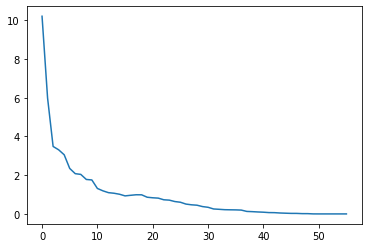

[ 1.02051146e+01  5.98616083e+00  3.48292928e+00  3.30983741e+00
  3.05407620e+00  2.34773018e+00  2.07786342e+00  2.04044064e+00
  1.77913782e+00  1.75381754e+00  1.31472450e+00  1.19161322e+00
  1.09758036e+00  1.06730481e+00  1.01572378e+00  9.30984116e-01
  9.61217133e-01  9.88622772e-01  9.86194063e-01  8.61177970e-01
  8.33168525e-01  8.15371742e-01  7.29804343e-01  7.11525027e-01
  6.38580943e-01  6.02933177e-01  5.08071163e-01  4.70540089e-01
  4.49828376e-01  3.78721830e-01  3.42139908e-01  2.55367653e-01
  2.37798826e-01  2.18400869e-01  2.12359790e-01  2.07992937e-01
  1.97872157e-01  1.28830437e-01  1.16877465e-01  1.00902130e-01
  8.85978265e-02  6.86039185e-02  6.49921543e-02  4.73210301e-02
  3.70977257e-02  2.73443961e-02  2.66484805e-02  1.49263262e-02
  1.41461128e-02  1.10012709e-03  1.28821561e-05  1.41503490e-06
  1.89609443e-07  1.23889630e-15 -4.49935111e-16  0.00000000e+00]


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalize the data
X = StandardScaler().fit_transform(X)

# Transpose X
Xt = X.T
Cx = np.cov(Xt)

# Calculate the eigenvalues and eigenvectors
eig_val, eig_vec = np.linalg.eig(Cx)

# Print scree plot
plt.plot(eig_val)
plt.show()

print(eig_val)

In [10]:
# All components above 1 selected for PCA
sklearn_pca = PCA(n_components=15)
X = sklearn_pca.fit_transform(X)

# Print the percentage for each component
print(
    'The percentage of total variance in the dataset explained by the total',
    'components from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_.sum())

The percentage of total variance in the dataset explained by the total components from Sklearn PCA.
 0.7585181244210599


In [11]:
# Evaluate the Random Forest Model
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X, Y, cv=10)

array([0.91726627, 0.92101826, 0.92303674, 0.92631379, 0.92464973,
       0.92510093, 0.923888  , 0.92350804, 0.92158073, 0.90982283])

## Model 3: Without Payment Amount or Outstanding Principal
Lets see if a random forest can be created with an accuracy above 90% without the payment amount or principal. The columns associated with those variables were removed and fited into 14 components via PCA. The results of these steps are discussed in the 'Summary and Conclusion' section. 

In [12]:
# X is the feature variable without the target, payment amt, or principal
X = y2015.drop(['loan_status', 'out_prncp', 'out_prncp_inv',
             'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
             'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt'], 
            axis =1)

# Assign dummies to all categorical variables
X = pd.get_dummies(X)

# Drop NA Columns
X = X.dropna(axis=1)

# Select only variables that are numeric
X = X.select_dtypes(include=['float64'])

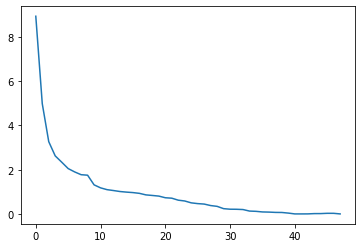

[8.94262523e+00 4.98620853e+00 3.26848129e+00 2.62469449e+00
 2.34139579e+00 2.05097757e+00 1.90026923e+00 1.77422403e+00
 1.75185195e+00 1.31501023e+00 1.17910055e+00 1.09753751e+00
 1.05747816e+00 1.01325502e+00 9.86381843e-01 9.64941208e-01
 9.30614796e-01 8.61053334e-01 8.34753977e-01 8.06054266e-01
 7.31485864e-01 7.11559827e-01 6.21646900e-01 5.85051224e-01
 5.00815450e-01 4.66115470e-01 4.45558196e-01 3.78354053e-01
 3.41990324e-01 2.37918479e-01 2.13134338e-01 2.09896064e-01
 1.97897269e-01 1.28692795e-01 1.16880540e-01 8.93188916e-02
 8.20028892e-02 6.86049508e-02 6.49925791e-02 3.71074768e-02
 3.46832040e-16 7.24728526e-06 1.10044088e-03 1.41474949e-02
 1.49352278e-02 2.73507521e-02 2.66378625e-02 0.00000000e+00]


In [13]:
# Normalize the data
X = StandardScaler().fit_transform(X)

# Transpose X
Xt = X.T
Cx = np.cov(Xt)

# Calculate the eigenvalues and eigenvectors
eig_val, eig_vec = np.linalg.eig(Cx)

# Print scree plot
plt.plot(eig_val)
plt.show()

print(eig_val)

In [14]:
# All components above 1 selected for PCA
sklearn_pca = PCA(n_components=14)
X = sklearn_pca.fit_transform(X)

# Print the percentage for each component
print(
    'The percentage of total variance in the dataset explained by the total',
    'components from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_.sum())

The percentage of total variance in the dataset explained by the total components from Sklearn PCA.
 0.7509350465639137


In [15]:
# Evaluate the Random Forest Model
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X, Y, cv=10)

array([0.67604664, 0.67621287, 0.67827883, 0.68393056, 0.68912372,
       0.68563287, 0.68887886, 0.68854639, 0.6909065 , 0.69429535])

## Summary and Conclusion
The two random forest above have very interesting results in comparision to the original random forest. The second model, just PCA, performed the best as the accuracy was still above 90% and the variance was very small incomparison to the original. The third model was the worst model in terms of accuracy. By removing the key variables principle and payment amount, the accuracy of the model dropped from 90% + to 67%-69%. The variance between cross folds was low due to the PCA cutting out most of the noise in the data. Overall, this drill was a great example of what happens to a model when key variables are removed. 